In [16]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as scio

Data = scio.loadmat('data_sets/ex8_movies.mat')
print(Data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'Y', 'R'])


In [17]:
Y = Data['Y'] # a num_movies * num_users stores the ratings y(i,j)(from 1 to 5)
R = Data['R'] # an binary-valued indicator matrix, where R(i,j) = 1 if user j gavc a rating to movie i, and R(i,j) = 0 otherwise.

print(Y.shape)
print(R.shape)

(1682, 943)
(1682, 943)


In [18]:
Data_2 = scio.loadmat('data_sets/ex8_movieParams.mat')
print(Data_2.keys())

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Theta', 'num_users', 'num_movies', 'num_features'])


In [19]:
X = Data_2['X']
Theta = Data_2['Theta']
num_users, num_movies, num_features = Data_2['num_users'], Data_2['num_movies'], Data_2['num_features']
print(X.shape)
print(Theta.shape)
print('num_users:{0}, num_movies:{1}, num_features:{2}'.format(num_users, num_movies, num_features))

(1682, 10)
(943, 10)
num_users:[[943]], num_movies:[[1682]], num_features:[[10]]


In [20]:
'''
Compute the average movie rating for the first movie (Toy Story)
'''
print(np.sum(Y[0]) / np.sum(R[0])) # note that R(i,j) = 0 denotes user j dosen't gave a rating to a movie i

3.8783185840707963


Text(0, 0.5, 'Movies(1682)')

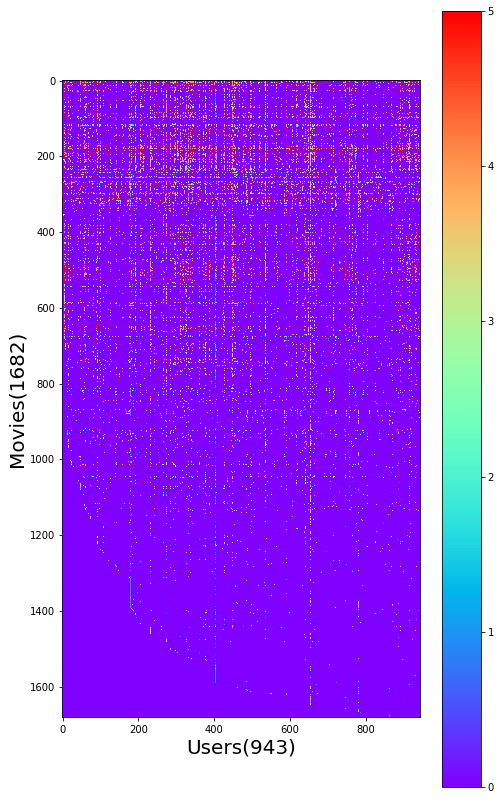

In [21]:
'''
Visualize the ratings matrix 
'''
plt.figure(figsize = (8, 8 * (1682. / 943.)))
plt.imshow(Y, cmap = 'rainbow')
plt.colorbar()
plt.xlabel('Users(%d)'%num_users, fontsize = 20)
plt.ylabel('Movies(%d)'%num_movies, fontsize = 20)

In [22]:
'''
Collaborative filtering learning algorithm
'''
def cofi_cost_func(params, y, r, num_users, num_movies, num_features, lmd = 0):
    '''
    params: which is a vector including X and Theta in order to use the optimization function fmin_ncg. 
    Note that you should be accumulating the cost for user j and movie i only if R(i,j) = 1
    '''
    # reshape params to get X and theta
    X = np.reshape(params[0: num_movies * num_features], (num_movies, num_features))
    Theta = np.reshape(params[num_movies * num_features :], (num_users, num_features))
    
    J = 0.5 * np.sum(np.square((X @ Theta.T - y))[np.where(r == 1)])
    reg = 0.5 * lmd * np.sum(np.square(Theta)) + 0.5 * lmd * np.sum(np.square(X))
    return J + reg

In [23]:
# reduce the number of datasets to test the cost function faster
nu = 4
nm = 5
nf = 3
x = X[0:nm, 0:nf]
theta = Theta[0:nu, 0:nf]
y = Y[0:nm, 0:nu]
r = R[0:nm, 0:nu]

# unroll parameters
params = np.r_[(x.flatten(), theta.flatten())]
J = cofi_cost_func(params, y, r, nu, nm, nf, lmd = 0)
print(J)

22.22460372568567


In [24]:
def cofi_grad_func(params, y, r, num_users, num_movies, num_features, lmd = 0):
    # reshape params to get X and theta
    X = np.reshape(params[0: num_movies * num_features], (num_movies, num_features))
    Theta = np.reshape(params[num_movies * num_features :], (num_users, num_features))
    
    X_grad = ((X @ Theta.T - y) * r) @ Theta + lmd * X
    Theta_grad = ((X @ Theta.T - y) * r).T @ X + lmd * Theta
    
    grad = np.r_[(X_grad.flatten(), Theta_grad.flatten())]
    return grad

def check_gradient(params, y, r, num_users, num_movies, num_features, lmd):
    '''
    梯度的数值检验（Numerical Gradient Checking）
    在代价函数上沿着切线的方向选择离两个非常近的点然后计算两个点的平均值用以估计梯度。
    '''
    e = 0.0001
    n_params = len(params)
    e_vec = np.zeros(n_params)
    
    grad = cofi_grad_func(params, y, r, num_users, num_movies, num_features, lmd)
    
    # Choose 10 random elements of param vector and compute the numerical gradient
    # Every time only change one value in the e_vec, and it should be recovered after computing. 
    for i in range(10):
        idx = np.random.randint(0, n_params)
        e_vec[idx] = e
        loss1 = cofi_cost_func(params - e_vec, y, r, num_users, num_movies, num_features, lmd)
        loss2 = cofi_cost_func(params + e_vec, y, r, num_users, num_movies, num_features, lmd)
        num_grad = (loss2 - loss1) / (2 * e)
        e_vec[idx] = 0
        # np.linalg.norm 表示求范数，默认是：根号下求平方和
        # calculate a single diff
        diff = np.linalg.norm(num_grad - grad[idx]) / np.linalg.norm(num_grad + grad[idx])
        print('%0.15f \t %0.15f \t %0.15f' %(num_grad, grad[idx], diff))
                               

In [25]:
print('Checking gradient with lambda = 0 ...')
check_gradient(params, y, r, nu, nm, nf, lmd = 0)
print('Checking gradient with lambda = 1.5 ...')
check_gradient(params, y, r, nu, nm, nf, lmd = 1.5)

Checking gradient with lambda = 0 ...
0.000000000000000 	 0.000000000000000 	 nan
-0.803780061460202 	 -0.803780061452057 	 0.000000000005067
0.000000000000000 	 0.000000000000000 	 nan
-7.160044429763701 	 -7.160044429740946 	 0.000000000001589
-0.740408710768747 	 -0.740408710778314 	 0.000000000006461
-3.474107886720645 	 -3.474107886729185 	 0.000000000001229
-0.832407133088964 	 -0.832407133096985 	 0.000000000004818
0.000000000000000 	 0.000000000000000 	 nan
-0.740408710768747 	 -0.740408710778314 	 0.000000000006461
-0.568195965513496 	 -0.568195965515757 	 0.000000000001990
Checking gradient with lambda = 1.5 ...
2.101362561379716 	 2.101362561388682 	 0.000000000002133
-0.647874841526175 	 -0.647874841514519 	 0.000000000008996
0.603080880985374 	 0.603080880979296 	 0.000000000005039
0.258398223902390 	 0.258398223889248 	 0.000000000025429
-2.997914223925591 	 -2.997914223943359 	 0.000000000002963
0.490265406352108 	 0.490265406355578 	 0.000000000003538
-10.13985478129697

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars


In [26]:
'''
Learning moive recommendations
'''
movies = []
with open('data_sets/movie_ids_mod.txt', 'r', encoding = 'utf-8') as f:
    for line in f:
        movies.append(' '.join(line.strip().split(' ')[1:]))

print(movies[:10])

['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', 'Get Shorty (1995)', 'Copycat (1995)', 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)', 'Twelve Monkeys (1995)', 'Babe (1995)', 'Dead Man Walking (1995)', 'Richard III (1995)']


In [28]:
my_ratings = np.zeros((1682, 1))

my_ratings[0] = 4 
my_ratings[97] = 2
my_ratings[6] = 3
my_ratings[11] = 5
my_ratings[53] = 4
my_ratings[63] = 5
my_ratings[65] = 3
my_ratings[68] = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

print('\n\nNew user ratings:\n')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated %d for %s\n' %(my_ratings[i], movies[i]))



New user ratings:

Rated 4 for Toy Story (1995)

Rated 3 for Twelve Monkeys (1995)

Rated 5 for Usual Suspects, The (1995)

Rated 4 for Outbreak (1995)

Rated 5 for Shawshank Redemption, The (1994)

Rated 3 for While You Were Sleeping (1995)

Rated 5 for Forrest Gump (1994)

Rated 2 for Silence of the Lambs, The (1991)

Rated 4 for Alien (1979)

Rated 5 for Die Hard 2 (1990)

Rated 5 for Sphere (1998)



In [35]:
Y = np.c_[Y, my_ratings]
R = np.c_[R, my_ratings != 0]

In [63]:
def normalize_ratings(y, r):
    '''
    computing the mean is only including rating movies 
    '''
    mean = (np.sum(y, axis = 1) / np.sum(r, axis = 1)).reshape((len(y), 1))
    y_norm = (y - mean) * r # r(i,j) = 0 denotes user j doesn't gave a rating to movie i.
    return y_norm, mean

Y_norm, Y_mean = normalize_ratings(Y, R)
nu = Y.shape[1]
nm = Y.shape[0]
nf = 10

In [64]:
# randomly initialize parameters
X = np.random.random((nm, nf))
Theta = np.random.random((nu, nf))
init_params = np.r_[X.flatten(), Theta.flatten()]
lmd = 10

In [65]:
import scipy.optimize as opt

res = opt.minimize(fun = cofi_cost_func,
                   x0 = init_params,
                   args = (Y_norm, R, nu, nm, nf, lmd),
                   method = 'TNC',
                   jac = cofi_grad_func,
                   options = {'maxiter': 100, 'disp':True})

In [66]:
params = res.x
X = np.reshape(params[0: nm * nf], (nm, nf))
Theta = np.reshape(params[nm * nf:], (nu, nf))

In [73]:
'''
Predict the ratings of movies and make movie recommendations
'''
pred_mat = X @ Theta.T # all users' movie ratings. Note that if you want to watch all predicting ratings, don't forget to add the mean.

pred_my = pred_mat[:, -1] + Y_mean.flatten()

pred_sorted_idx = np.argsort(pred_my)[::-1] # 排序并翻转，使之从大到小排列

In [74]:
print("\nTop recommendations for you:\n")
for i in range(50):
    print('Predicting rating %0.1f for movie %s.\n'
          %(pred_my[pred_sorted_idx[i]],movies[pred_sorted_idx[i]]))

print("\nOriginal ratings provided:\n")
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated %d for movie %s.\n'% (my_ratings[i],movies[i]))
    


Top recommendations for you:

Predicting rating 5.0 for movie Great Day in Harlem, A (1994).

Predicting rating 5.0 for movie Aiqing wansui (1994).

Predicting rating 5.0 for movie Marlene Dietrich: Shadow and Light (1996).

Predicting rating 5.0 for movie Santa with Muscles (1996).

Predicting rating 5.0 for movie Entertaining Angels: The Dorothy Day Story (1996).

Predicting rating 5.0 for movie Saint of Fort Washington, The (1993).

Predicting rating 5.0 for movie Star Kid (1997).

Predicting rating 5.0 for movie Someone Else's America (1995).

Predicting rating 5.0 for movie Prefontaine (1997).

Predicting rating 5.0 for movie They Made Me a Criminal (1939).

Predicting rating 4.6 for movie Pather Panchali (1955).

Predicting rating 4.6 for movie Star Wars (1977).

Predicting rating 4.6 for movie Wrong Trousers, The (1993).

Predicting rating 4.6 for movie Shawshank Redemption, The (1994).

Predicting rating 4.6 for movie Close Shave, A (1995).

Predicting rating 4.5 for movie May